In [1]:
%load_ext autoreload
import sys
sys.path.append("../..")

# Helium

In [19]:
%autoreload

import numpy as np

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


import darkhistory.physics as phys
import darkhistory.history.tla as tla

## TLA with Helium

The TLA with helium looks like the following set of equations (from astro-ph/9909275):

$$ \frac{dx_\text{p}}{dz} = \mathcal{C}_\text{H} \left(x_\text{e} x_\text{p} n_\text{H} \alpha_\text{H} - \beta_\text{H} (1 - x_p) e^{- \nu_{\text{H} 2s} / T_M} \right)$$

$$ \frac{dx_\text{HeII}}{dz} = \mathcal{C}_\text{He} \left( 
    x_e x_\text{HeII} n_\text{H} \alpha_\text{HeI} - \beta_\text{HeI} \left( f_\text{He} - x_\text{HeII} \right) e^{- \nu_{\text{HeI 2}^1s} / T_M} \right) $$
    
where

$$\mathcal{C}_\text{H} = \frac{1 + K_\text{H} \Lambda_\text{H} n_\text{H} (1 - x_p)}{H(z) (1+z) \left( 1 + K_\text{H} (\Lambda_\text{H} + \beta_\text{H}) n_\text{H} (1 - x_p) \right)} $$

and similarly

$$\mathcal{C}_\text{He} = \frac{1 + K_\text{HeI} \Lambda_\text{He} n_\text{H} \left(f_\text{He} - x_\text{HeII} \right) e^{-\nu_\text{ps}/T_M}}{H(z) (1+z) \left( 1 + K_\text{HeI} (\Lambda_\text{He} + \beta_\text{HeI}) n_\text{H} (f_\text{He} - x_\text{HeII}) e^{- \nu_\text{ps}/T_M} \right)} $$

$\mathcal{C}_\text{H}$ should be the Peebles-C factor that we already have (we will check this numerically below), while $\mathcal{C}_\text{He}$ is the equivalent factor for helium.

Let's try to obtain the solution to these equations, together with the usual temperature evolution equations.

First, let's check that our Peebles-C factor expressions are the same. Note that there is a factor of 4 difference in our definition of $\beta$, and also the factor of $H(z) (1+z)$ which converts between $dz$ and $dt$. Also, $\beta$ should be evaluated at $T_R$ as per the HyREC paper. 

In [3]:
def C_H(rs, xp, T_m):
    lambda_H_2p = 2*np.pi*phys.hbar*phys.c/phys.lya_eng
    K_H = lambda_H_2p**3/(8*np.pi*phys.hubble(rs))
    Lambda_H = 8.22458
    
    numer = 1 + K_H*Lambda_H*phys.nH*rs**3*(1 - xp)
    denom = numer + K_H*4*(1-xp)*phys.beta_ion(phys.TCMB(rs))*phys.nH*rs**3
    
    return numer/denom/(phys.hubble(rs)*rs)


rs = 700000
xp = 0
T_m = 3
# Should be equal.
print(C_H(rs, xp, T_m))
print(phys.peebles_C(xp, rs)/phys.hubble(rs)/rs)

1.2284679035815046e-07
1.2292772586630703e-07


This check confirms that we can use the same code as in `physics` and `tla` to solve for the hydrogen part of recombination, as well as the temperature evolution of course. We now need to code up the helium side of things.

In [4]:
def alpha_HeI_recomb(T_m):
    
    q = 10**-16.744
    p = 0.711
    T_1 = 10**5.114 * phys.kB # in eV
    T_2 = 3. * phys.kB # in eV
    
    # in cm^3 s^-1
    return 1e6*q/(
        np.sqrt(T_m/T_2)
        *(1 + np.sqrt(T_m/T_2))**(1-p)
        *(1 + np.sqrt(T_m/T_1))**(1+p) 
    )

def beta_HeI_ion(T_rad):
    # multiply by 4 to get agreement with RECFAST.
    reduced_mass = phys.mp*phys.me/(phys.mp + phys.me)
    de_broglie_wavelength = (
        phys.c * 2*np.pi*phys.hbar
        / np.sqrt(2 * np.pi * reduced_mass * T_rad)
    )
    
    E2s = phys.He_ion_eng - 2*np.pi*phys.hbar*phys.c/60.1404e-7
    
    return (
        (1/de_broglie_wavelength)**3/4
        * np.exp(-E2s/T_rad) * alpha_HeI_recomb(T_rad)
    )
    

def C_He(rs, xHeII, T_m):
    
    lambda_HeI_2_1p = 58.4334e-7
    
    Lambda_He = 51.3
    
    f_He = phys.nHe/phys.nH
    
    K_HeI = lambda_HeI_2_1p**3/(8*np.pi*phys.hubble(rs))
    
    E_ps = 2*np.pi*phys.hbar*(
        phys.c/58.4334e-7 - phys.c/60.1404e-7
    )
    
    numer = 1 + K_HeI*Lambda_He*phys.nH*rs**3*(f_He - xHeII)*np.exp(-E_ps/T_m)
    denom = numer + K_HeI*4*beta_HeI_ion(phys.TCMB(rs))*phys.nH*rs**3*(f_He - xHeII)*np.exp(-E_ps/T_m)
    
    return numer/denom
    
    

Now for the equivalent of `get_history`. 

In [13]:
from scipy.integrate import odeint

def compton_cooling_rate(xHII, xHeII, xHeIII, T_m, rs):

    xe = xHII + xHeII + 2*xHeIII

    return (
        4 * phys.thomson_xsec * 4 * phys.stefboltz / phys.me
        * xe * phys.nH*rs**3 * (phys.TCMB(rs) - T_m)
        * phys.TCMB(rs)**4
    )

def get_history_He(
    init_cond, f_H_ion_in, f_H_exc_in, f_heating_in, 
    dm_injection_rate_in, rs_vec, mxstep = 0
):

    def f_H_ion(rs, xHI, xHeI, xHeII):
        if isinstance(f_H_ion_in, float):
            return f_H_ion_in
        elif callable(f_H_ion_in):
            return f_H_ion_in(rs, xHI, xHeI, xHeII)
        else:
            raise TypeError('f_H_ion_in must be float or an appropriate function.')

    def f_H_exc(rs, xHI, xHeI, xHeII):
        if isinstance(f_H_exc_in, float):
            return f_H_exc_in
        elif callable(f_H_exc_in):
            return f_H_exc_in(rs, xHI, xHeI, xHeII)
        else:
            raise TypeError('f_H_exc_in must be float or an appropriate function.')

    def f_heating(rs, xHI, xHeI, xHeII):
        if isinstance(f_heating_in, float):
            return f_heating_in
        elif callable(f_heating_in):
            return f_heating_in(rs, xHI, xHeI, xHeII)
        else:
            raise TypeError('f_heating_in must be float or an appropriate function.')

    def dm_injection_rate(rs):
        if isinstance(dm_injection_rate_in, float):
            return dm_injection_rate_in
        elif callable(dm_injection_rate_in):
            return dm_injection_rate_in(rs)
        else:
            raise TypeError('dm_injection_rate_in must be a float or an appropriate function.')
            
    chi = phys.nHe/phys.nH
    
    def xHII(yHII):
            return 0.5 + 0.5*np.tanh(yHII)
    def xHeII(yHeII):
        return chi/2 + chi/2*np.tanh(yHeII)
    def xHeIII(yHeIII):
        return chi/2 + chi/2*np.tanh(yHeIII)
    
    def tla(var, rs):

        def dT_dz(yHII, yHeII, yHeIII, T_m, rs):

            xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)
            xHI = 1 - xHII(yHII)
            xHeI = chi - xHeII(yHeII) - xHeIII(yHeIII)

            # This rate is temperature loss per redshift.
            adiabatic_cooling_rate = 2 * T_m/rs

            return adiabatic_cooling_rate + (
                - phys.dtdz(rs)*(
                    compton_cooling_rate(
                        xHII(yHII), xHeII(yHeII), xHeIII(yHeIII), T_m, rs
                    )
                    + f_heating(rs, xHI, xHeI, xHeII(yHeII)) * dm_injection_rate(rs)
                )
            )/ (3/2 * phys.nH*rs**3 * (1 + chi + xe))

        def dyHII_dz(yHII, yHeII, yHeIII, T_m, rs):

            if 1 - xHII(yHII) < 1e-6 and rs < 100:
                # At this point, leave at 1 - 1e-6
                return 0
            
            if yHII > 14 or yHII < -14:
                return 0

            xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)
            ne = xe * phys.nH*rs**3
            xHI = 1 - xHII(yHII)
            xHeI = chi - xHeII(yHeII) - xHeIII(yHeIII)

            return 2 * np.cosh(yHII)**2 * -phys.dtdz(rs) * (
                # Recombination processes
                - phys.peebles_C(xHII(yHII), rs) * (
                    phys.alpha_recomb(T_m) * xHII(yHII)*xe * phys.nH * rs**3
                    - phys.beta_ion(phys.TCMB(rs)) * xHI
                        * np.exp(-phys.lya_eng/T_m)
                )
                # DM injection. Note that C = 1 at late times.
                + f_H_ion(rs, xHI, xHeI, xHeII(yHeII)) * dm_injection_rate(rs)
                    / (phys.rydberg * phys.nH * rs**3)
                + (1 - phys.peebles_C(xHII(yHII), rs)) * (
                    f_H_exc(rs, xHI, xHeI, xHeII(yHeII)) * dm_injection_rate(rs)
                    / (phys.lya_eng * phys.nH * rs**3)
                )
            )

        def dyHeII_dz(yHII, yHeII, yHeIII, T_m, rs):

            E_HeI21s = 2*np.pi*phys.hbar*phys.c/60.1404e-7

            if 1 - xHII(yHII) < 1e-6 and rs < 100:
                # At this point, leave at 1 - 1e-6
                return 0

            xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)
            ne = xe * phys.nH*rs**3
            xHeI = chi - xHeII(yHeII) - xHeIII(yHeIII)
            

            return 2 * np.cosh(yHeII)**2 * -phys.dtdz(rs) * (
                -C_He(rs, xHeII(yHeII), T_m) * (
                    alpha_HeI_recomb(T_m) * xHeII(yHeII)*xe * phys.nH * rs**3
                    - beta_HeI_ion(phys.TCMB(rs)) * (chi - xHeII(yHeII))
                    *np.exp(-E_HeI21s/T_m)
                )
            )

        def dyHeIII_dz(yHII, yHeII, yHeIII, T_m, rs):

            if 1 - xHII(yHII) < 1e-6 and rs < 100:
                # At this point, leave at 1 - 1e-6
                return 0

            xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)
            ne = xe * phys.nH*rs**3

            return 0

        T_m, yHII, yHeII, yHeIII = var[0], var[1], var[2], var[3]
        
        return [
            dT_dz(yHII, yHeII, yHeIII, T_m, rs),
            dyHII_dz(yHII, yHeII, yHeIII, T_m, rs),
            dyHeII_dz(yHII, yHeII, yHeIII, T_m, rs),
            dyHeIII_dz(yHII, yHeII, yHeIII, T_m, rs)
        ]

    if init_cond[1] == 1:
        init_cond[1] = 1 - 1e-12
    if init_cond[2] == 0:
        init_cond[2] = 1e-12
    elif init_cond[2] == phys.nHe/phys.nH:
        init_cond[2] = phys.nHe/phys.nH - 1e-4
    if init_cond[3] == 0:
        init_cond[3] = 1e-12

    init_cond[1] = np.arctanh(2*(init_cond[1] - 0.5))
    init_cond[2] = np.arctanh(2/chi * (init_cond[2] - chi/2))
    init_cond[3] = np.arctanh(2/chi *(init_cond[3] - chi/2))

    soln = odeint(
        tla, init_cond, rs_vec, mxstep = mxstep
    )
    
    soln[:,1] = 0.5 + 0.5*np.tanh(soln[:,1])
    soln[:,2] = (
        chi/2 + chi/2*np.tanh(soln[:,2])
    )
    soln[:,3] = (
        chi/2 + chi/2*np.tanh(soln[:,3])
    )

    return soln


In [15]:
rs_vec_std = np.flipud(1. + np.arange(3000))
init_cond = [phys.TCMB(3000), 1., phys.nHe/phys.nH, 0]

soln = get_history_He(init_cond, 0., 0., 0., 0., rs_vec_std, mxstep=0)
rs_vec_std = np.flipud(1 + np.arange(3000))
init_cond = [phys.TCMB(3000), 1., phys.nHe/phys.nH*0, 0]
soln_DH = tla.get_history(init_cond, 0., 0., 0., 0., rs_vec_std, reion_switch=False)



[100, 3000, 1e-08, 1.25]

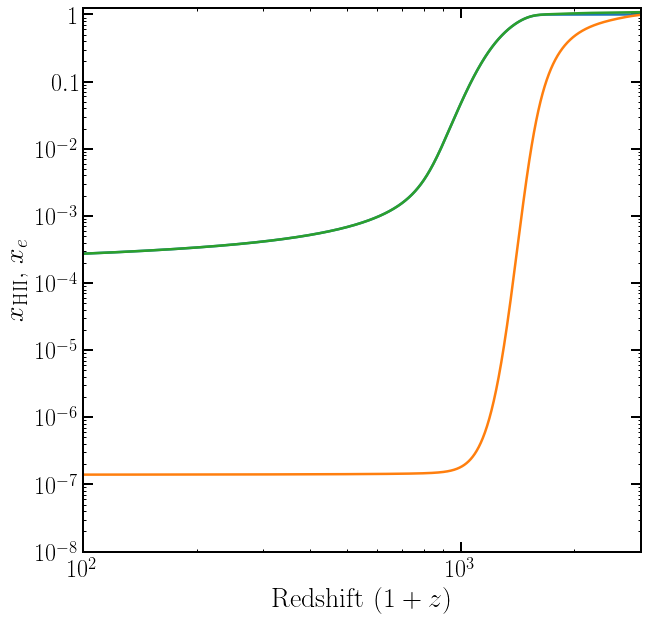

In [23]:
plt.figure()

plt.loglog()

plt.plot(rs_vec_std, soln[:,1])
plt.plot(rs_vec_std, soln[:,2]*phys.nH/phys.nHe)
plt.plot(rs_vec_std, soln[:,1] + soln[:,2])
# plt.plot(rs_vec_std, soln_DH[:,1])

plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'$x_\mathrm{HII}$, $x_e$')

plt.axis([100, 3000, 1e-8, 1.25])

In [8]:
soln_DH[:,0]

array([0.70459618, 0.70436114, 0.70412627, ..., 0.        , 0.        ,
       0.        ])

In [72]:
rs = 16

print(2e-4*phys.nH*rs**3*phys.alpha_recomb(phys.TCMB(rs))/phys.hubble(rs))
print(2e-4*phys.nH*rs**3*alpha_HeI_recomb(phys.TCMB(rs))/phys.hubble(rs))

0.026026717805557896
0.005688943237661129


In [73]:
rs=10

(1 - 0.99)*phys.nH*rs**3*phys.photo_ion_xsec(np.array([24.6]),'HI')*phys.c/phys.hubble(rs)

array([1794.19815764])